# **Clustering With Pyspark**

## **Configuration**

In [ ]:
#Installation
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

#spark
import findspark
findspark.init()

#Creating Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ClusteringWithSPyspark").getOrCreate()

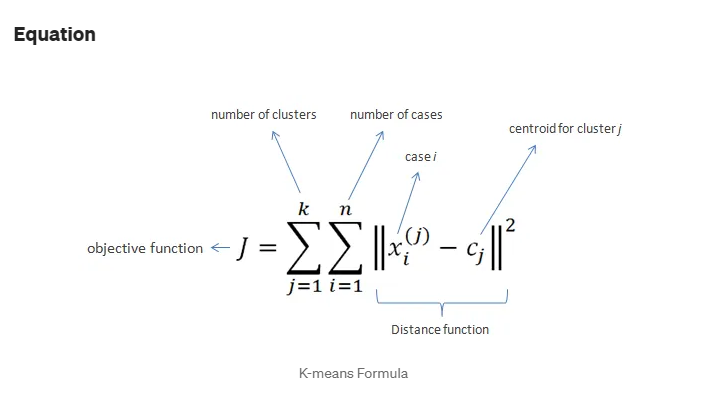

## **Silhoute Co-efficient Score:**

Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The function returns the mean Silhouette Coefficient over all samples.

## **Data Load**

In [ ]:
from pyspark import SparkFiles
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Iris.csv"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("Iris.csv"), header=True, inferSchema=True)
df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



## **Data Pre-processing**

In [ ]:
# Assembling features into a single column
assembler = VectorAssembler(inputCols=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"], outputCol="features")
data_df = assembler.transform(df)

# Scaling the features
# scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
# scaler_model = scaler.fit(data_df)
# data_df = scaler_model.transform(data_df)

data_df.show(5)

+---+-------------+------------+-------------+------------+-----------+-----------------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|         features|
+---+-------------+------------+-------------+------------+-----------+-----------------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
+---+-------------+------------+-------------+------------+-----------+-----------------+
only showing top 5 rows



## **Finding Optimal K value**

In [ ]:
wssse_values =[]
# evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', \
#                                 metricName='silhouette', distanceMeasure='squaredEuclidean')

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')


for i in range(2,8):
    # KMeans_mod = KMeans(featuresCol='scaled_features', k=i, seed=42)
    KMeans_mod = KMeans(featuresCol='features', k=i, seed=42)
    KMeans_fit = KMeans_mod.fit(data_df)
    output = KMeans_fit.transform(data_df)
    score = evaluator.evaluate(output)
    wssse_values.append(score)
    print("WSSE Score:",score)

Silhouette Score: 0.8501515983265806
Silhouette Score: 0.7342113066202725
Silhouette Score: 0.6778502821786409
Silhouette Score: 0.5668651038594757
Silhouette Score: 0.651711699322729
Silhouette Score: 0.5483960647256124


## **Plotting Silhoutte Score**

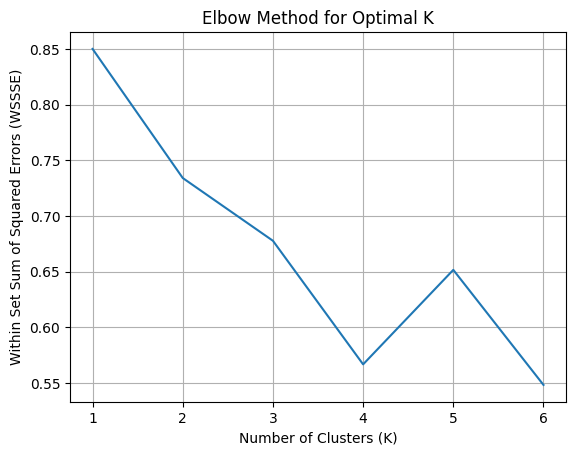

In [ ]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

## **Performing K-Means Clustering**

In [ ]:
# Define the K-means clustering model
# kmeans = KMeans(k=6, featuresCol="scaled_features", predictionCol="cluster")
kmeans = KMeans(k=4, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_df)

# Assigning the data points to clusters
clustered_data = kmeans_model.transform(data_df)

## **Evaluating Performance**

In [ ]:
output = KMeans_fit.transform(data_df)
wssse = evaluator.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5483960647256124


## **Visualizing the Result**

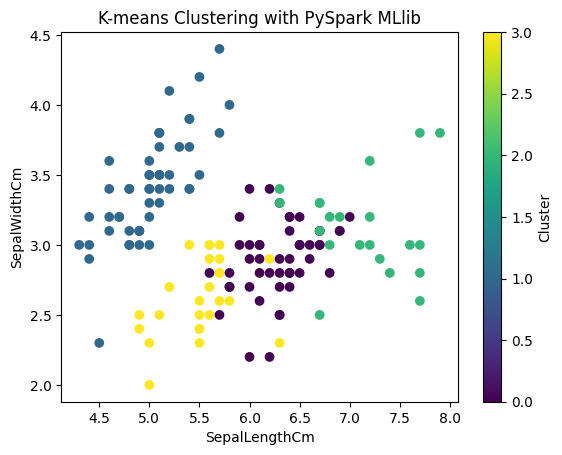

In [ ]:
# Converting to Pandas DataFrame
clustered_data_pd = clustered_data.toPandas()

# Visualizing the results
plt.scatter(clustered_data_pd["SepalLengthCm"], clustered_data_pd["SepalWidthCm"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("SepalLengthCm")
plt.ylabel("SepalWidthCm")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

## **Cluster Centers**

In [ ]:
centers = kmeans_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[6.29361702 2.9        4.95106383 1.72978723]
[5.006 3.418 1.464 0.244]
[7.08695652 3.12608696 6.01304348 2.14347826]
[5.58       2.63333333 3.98666667 1.23333333]
